<a href="https://colab.research.google.com/github/nuttycod3r/ai4imaging_maastricht/blob/master/ai4imaging_for_trainning_CNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [86]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [87]:
cd /content/gdrive/'My Drive'

/content/gdrive/My Drive


In [88]:
!pip install livelossplot 


In [89]:
import tensorflow as tf
import tensorflow.keras.backend as K
#Check availableGPUs

import os,re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import model_selection,metrics

import tensorflow.keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, callbacks, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense,Flatten,GlobalAveragePooling2D,Dropout
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.models import Model
from livelossplot import PlotLossesKeras

K.set_image_data_format('channels_last')

print(tf.__version__)

1.15.0


In [90]:
y = np.load('y_train.npy').astype(np.float32)

new_y = np.zeros(y.shape[0]*3)

for i in range(len(y)):
    new_y[3*i] = y[i]
    new_y[3*i+1] = y[i]
    new_y[3*i+2] = y[i]

print(len(y),y, new_y.shape)
new_y

96 [1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.] (288,)


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0.,
       0., 1., 1., 1., 1.

In [81]:
X=np.load("X_train.npy")

new_X = np.zeros((X.shape[0]* X.shape[-1],X.shape[1], X.shape[2],1))

for i in range(X.shape[0]):
    new_X[3*i,:,:,0] = X[i,:,:,0]
    new_X[3*i+1,:,:,0] = X[i,:,:,1]
    new_X[3*i+2,:,:,0] = X[i,:,:,2]

print(new_X.shape)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(new_X, new_y, test_size=0.2, random_state=8)
print(X_train.shape)

(288, 300, 300, 1)
(230, 300, 300, 1)


In [0]:
def CNN_xception(input_shape):
    # create the base pre-trained model
    base_model = Xception(weights=None, include_top=False,input_shape=input_shape)
    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # let's add a fully-connected layer
    x = Dropout(0.5, noise_shape=None, seed=None)(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)
    # this is the model we will train
    return Model(inputs=base_model.input, outputs=predictions)


#Define callbacks
def cosine_annealing(x,c_lr):
    lr = 3e-5 
    epochs = 200
    print('Learning rate is: %s'%str(lr*(np.cos(np.pi*x/epochs)+1.)/2))
    return lr*(np.cos(np.pi*x/epochs)+1.)/2
    
#learning_rate = callbacks.LearningRateScheduler(cosine_annealing)

filepath=r"weights-improvement-{epoch:02d}-{val_acc:.3f}.hdf5"
checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [PlotLossesKeras(),checkpoint]

In [0]:

from keras.utils.data_utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator

class BalancedDataGenerator(Sequence):
    """ImageDataGenerator + RandomOversampling"""
    def __init__(self, x, y, datagen, batch_size=32):
        self.datagen = datagen
        self.batch_size = batch_size
        self._shape = x.shape        
        datagen.fit(x)
        self.gen, self.steps_per_epoch = balanced_batch_generator(x.reshape(x.shape[0], -1), y, sampler=RandomOverSampler(), batch_size=self.batch_size, keep_sparse=True)

    def __len__(self):
        return self._shape[0] // self.batch_size

    def __getitem__(self, idx):
        x_batch, y_batch = self.gen.__next__()
        x_batch = x_batch.reshape(-1, *self._shape[1:])
        return self.datagen.flow(x_batch, y_batch, batch_size=self.batch_size).next()


In [91]:
#initializing the network
model = CNN_xception(X_train.shape[1:4])

model.compile(optimizer=optimizers.Adam(lr = 1e-4),loss='binary_crossentropy',metrics=['accuracy'])
#model.compile(optimizer=optimizers.Adam(lr = 1e-3),loss='cosine_proximity',metrics=['accuracy'])


datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    samplewise_std_normalization = True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    channel_shift_range=0.9,
    fill_mode = 'reflect', 
    horizontal_flip=True)

datagen.fit(X_train)

#class_weight = {0: 50.,
 #               1: 1.}

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

balanced_gen = BalancedDataGenerator(X_train, y_train, datagen, batch_size=10)
steps_per_epoch = balanced_gen.steps_per_epoch

#model.load_weights("weights-improvement-1283-0.914.hdf5")
model.load_weights("weights-improvement-76-0.983.hdf5")
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=10), validation_data=(X_test,y_test),
                    steps_per_epoch=balanced_gen.steps_per_epoch, epochs=2000, callbacks=callbacks_list, class_weight=class_weights)


#history = CNN_xception.fit(x = X_train,y = y_train,validation_data=(X_test,y_test),epochs=30,batch_size=10,callbacks=callbacks_list)



/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:355: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


KeyboardInterrupt: ignored

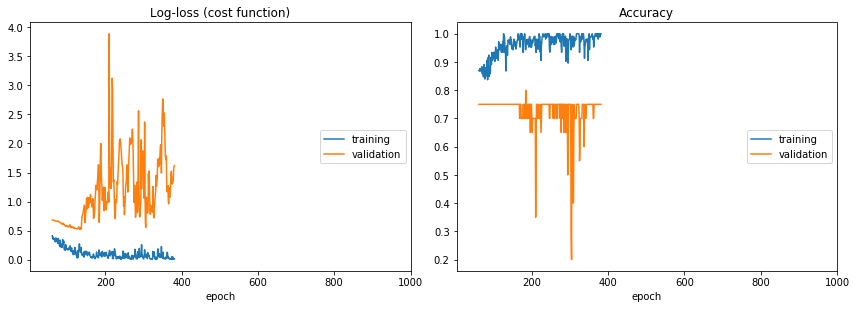

Log-loss (cost function):
training   (min:    0.003, max:    0.498, cur:    0.013)
validation (min:    0.522, max:    3.887, cur:    1.620)

Accuracy:
training   (min:    0.837, max:    1.000, cur:    1.000)
validation (min:    0.200, max:    0.800, cur:    0.750)

Epoch 00323: val_acc did not improve from 0.80000
8/8 [==============================] - 4s 448ms/step - loss: 0.0133 - acc: 1.0000 - val_loss: 1.6198 - val_acc: 0.7500
Epoch 324/1000
3/8 [==========>...................] - ETA: 1s - loss: 0.0125 - acc: 1.0000

KeyboardInterrupt: ignored

In [33]:
#initializing the network
model = CNN_xception(X_train.shape[1:4])

model.compile(optimizer=optimizers.Adam(lr = 1e-4),loss='binary_crossentropy',metrics=['accuracy'])

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    samplewise_std_normalization = True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    channel_shift_range=0.9,
    fill_mode = 'reflect', 
    horizontal_flip=True)

datagen.fit(X_train)

#class_weight = {0: 50.,
 #               1: 1.}

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
print(class_weights)
balanced_gen = BalancedDataGenerator(X_train, y_train, datagen, batch_size=15)
steps_per_epoch = balanced_gen.steps_per_epoch


history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=15), validation_data=(X_test,y_test),
                    steps_per_epoch=balanced_gen.steps_per_epoch, epochs=1000, callbacks=callbacks_list, class_weight=class_weights)


#history = CNN_xception.fit(x = X_train,y = y_train,validation_data=(X_test,y_test),epochs=30,batch_size=10,callbacks=callbacks_list)



In [0]:
model.load_weights("weights-improvement-02-0.983.hdf5")

In [98]:
test = np.load("X_test.npy").astype(np.float32)

new_test = np.zeros((test.shape[0]* test.shape[-1],test.shape[1], test.shape[2],1))

for i in range(test.shape[0]):
    new_test[3*i,:,:,0] = test[i,:,:,0]
    new_test[3*i+1,:,:,0] = test[i,:,:,1]
    new_test[3*i+2,:,:,0] = test[i,:,:,2]

print(new_X.shape)

print(test.shape)

(288, 300, 300, 1)
(20, 300, 300, 3)


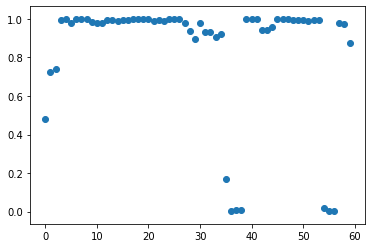

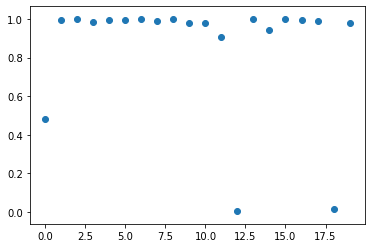

(20,) [0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1]


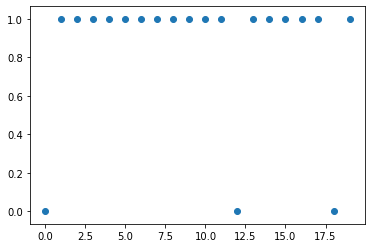

'\ny_pred = np.ones((20,))\nfor i in range(test.shape[0]):\n    y_pred[i] = pred[i]\n    y_pred[i]+= pred[i+1]\n    y_pred[i]+= pred[i+2]\n\nprint(y_pred.shape, y_pred)\n\n\n\n\nprint(y_pred.shape, y_pred)\ny_pred = pred.astype(np.int8)\nprint(y_pred.shape, y_pred)\n'

In [99]:
pred = model.predict(new_test, batch_size=10)

plt.scatter( [x for x in range(pred.shape[0])] , pred[:, 0] )
plt.show()

pred = model.predict(np.expand_dims(test[:,:,:,0], axis=3), batch_size=10)

plt.scatter( [x for x in range(pred.shape[0])] , pred[:, 0] )
plt.show()


pred[pred>0.5] = 1
pred[pred<=0.5] = 0

pred = pred.squeeze(-1).astype(np.int8)
print(pred.shape, pred)

plt.scatter( [x for x in range(pred.shape[0])] , pred[:] )
plt.show()

"""
y_pred = np.ones((20,))
for i in range(test.shape[0]):
    y_pred[i] = pred[i]
    y_pred[i]+= pred[i+1]
    y_pred[i]+= pred[i+2]

print(y_pred.shape, y_pred)




print(y_pred.shape, y_pred)
y_pred = pred.astype(np.int8)
print(y_pred.shape, y_pred)
"""

In [100]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

y_true = np.load("y_test_gt.npy").astype(np.int8)
print(y_true)
print(pred)
print(confusion_matrix(y_true, pred))

print(accuracy_score(y_true, pred))
print(f1_score(y_true, pred))

[0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0]
[0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1]
[[ 1  2]
 [ 2 15]]
0.8
0.8823529411764706


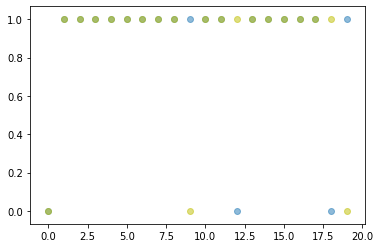

In [101]:
plt.scatter( [x for x in range(pred.shape[0])] , pred[:], alpha = '0.5' )
plt.scatter( [x for x in range(pred.shape[0])] , y_true[:] , c = 'y', alpha = '0.5' )

plt.show()

In [102]:

from sklearn.metrics import plot_confusion_matrix


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

ImportError: ignored